<a href="https://colab.research.google.com/github/xKDR/Legal-Notebooks/blob/main/disposal_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying case outcomes in India

We appreciate the valuable contributions of Susan Thomas, Siddarth Raman, Alena Thomas, and Sattik Biswas. We also thank our computing partner, E2E Networks.

# 2. Setting up the environment

## 2.1 Installing packages

To set up our cloud-based environment, we install the necessary Python packages using the pip command in Google Colab. Below is the code snippet used for installation:

In [ ]:
%%capture

# Package for running LLMs locally
!pip install langchain==0.3
!pip install langchain-core==0.3
!pip install langchain-community==0.3

# Package for reading PDF files
!pip install pdfplumber==0.11
!pip install pytesseract==0.3
!pip install pdf2image==1.17

# Machine learning packages
!pip install scikit-learn==1.5
!pip install nltk==3.8
!pip install lightgbm==4.5

# Other helpful libraries
!pip install tqdm==4.66
!pip install pandas==2.1
!pip install pillow==10.4
!pip install matplotlib==3.7

## 2.2 Import packages

After installing the necessary packages, we import the required libraries into our Python environment.

In [ ]:
import sqlite3 as db  # SQLite is a lightweight database library for managing database connections.
import io  # IO module to handle input and output operations.
import pdfplumber  # PDF processing library for extracting text from PDF files.
import pandas as pd  # Pandas is a powerful data manipulation and analysis library.

import pytesseract  # Python wrapper for Google's Tesseract-OCR Engine to perform optical character recognition (OCR).
from pdf2image import convert_from_bytes  # Converts PDF files into images for OCR processing.

import re  # Regular expressions library for string matching and manipulation.

from tqdm import tqdm  # Library for displaying progress bars during iterations.

from langchain_community.llms import Ollama # Library for connecting to Ollama

import matplotlib.pyplot as plt # 3.7.1

## 2.3 Install dependancies

We install additional dependencies required for specific functionalities in our analysis. These include:

**Poppler:** This package provides a collection of utilities for working with PDF documents. It includes tools for converting PDF files to various formats, extracting text from PDFs, and manipulating PDF content.

**Tesseract-OCR:** Tesseract is a powerful optical character recognition (OCR) engine that converts images of text into machine-readable text. It is particularly useful for extracting text from scanned documents or images embedded in PDF files. By installing Tesseract, we enable our program to perform OCR on images when direct text extraction is not feasible.

**PCI Utils** is a collection of utilities for inspecting and managing PCI (Peripheral Component Interconnect) devices in the system. This package provides tools that allow us to query information about the hardware components connected to the PCI bus, such as graphics cards, network interfaces, and other peripherals. It is useful when working with machine learning models that may require GPU acceleration, as it enables us to identify available hardware resources and ensure that the appropriate drivers are installed.

In [ ]:
%%capture

# !sudo apt-get install -y poppler-utils
# !sudo apt-get install tesseract-ocr
# !sudo apt install pciutils

import subprocess

# Check if 'poppler-utils' is installed
result = subprocess.run(["dpkg", "-l", "poppler-utils"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("poppler-utils is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "poppler-utils"])
else:
    print("poppler-utils is already installed.")

# Check if 'tesseract-ocr' is installed
result = subprocess.run(["dpkg", "-l", "tesseract-ocr"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("tesseract-ocr is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "tesseract-ocr"])
else:
    print("tesseract-ocr is already installed.")

# Check if 'pciutils' is installed
result = subprocess.run(["dpkg", "-l", "pciutils"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("pciutils is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "pciutils"])
else:
    print("pciutils is already installed.")


# 3. Orders database

In [ ]:
import os
import subprocess

# Path where the file should be downloaded
file_path = "orders.sqlite"

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    subprocess.run([
        "wget",
        "-O", file_path,
        "https://github.com/xKDR/order_substantive_classification/raw/refs/heads/main/orders.sqlite?download="
    ])
    print("File downloaded.")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


`wget` is used to download the SQLite database from a GitHub repository.  It contains court order PDFs. This database will provides orders as well as their labels.

In [ ]:
# @title 3.1 Helper functions to work with the database

# Function to read PDF text from BLOB
import pymupdf4llm
import io
import tempfile
import os

def read_pdf_text_from_blob(pdf_blob):
    """
    Reads a PDF from binary data and returns its markdown text content.

    :param pdf_blob: Binary data of the PDF.
    :return: Markdown text content of the PDF.
    """
    if pdf_blob is None:
        print("PDF binary data is None.")
        return ""

    try:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(delete=False) as temp_pdf:
            # Write the PDF blob to the temporary file
            temp_pdf.write(pdf_blob)
            temp_file_path = temp_pdf.name  # Get the path to the temp file

        # Use pymupdf4llm to convert the PDF to markdown
        md_text = pymupdf4llm.to_markdown(temp_file_path)

        # Clean up the temporary file
        os.remove(temp_file_path)

        return md_text

    except Exception as e:
        print(f"Error reading PDF with pymupdf4llm: {e}")
        return ""

def execute_query_and_return_dataframe(database_path,query):
    """
    Takes in a user  SQL query, executes it against the SQLite database at the specified path,
    and returns the results as a Pandas DataFrame.

    Parameters:
    - database_path: A string representing the full path to the SQLite database file.
    - query: User SQL query
    Returns:
    - A Pandas DataFrame containing the results of the executed query.
    """
    # Establish a connection to the SQLite database
    conn = db.connect(database_path)

    try:
        # Prompt the user for a SQL query
        query = query

        # Read SQL query into a DataFrame
        df = pd.read_sql_query(query, conn)

        # Return the DataFrame
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error
    finally:
        # Ensure the connection is closed even if an error occurs
        conn.close()

We define a couple of helper functions to facilitate interaction with the SQLite database. These functions include capabilities for reading PDF text from binary data, and executing SQL queries

In [ ]:
# @title 3.2 Load the database into a dataframe
db_path = "/content/orders.sqlite"

df_1 = execute_query_and_return_dataframe(db_path, "SELECT * from whether_substantive")

df_1

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-80-2021_01042021.pdf,non_substantive,BHC
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-579-2019_04012021.pdf,substantive,BHC
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,s-167-2022_13042022.pdf,substantive,BHC
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,substantive,BHC
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,s-844-2019_24092020.pdf,non_substantive,BHC
...,...,...,...,...
2008,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-220-2021_03032022.pdf,non_substantive,NCLT
2009,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-303-2021_25082021.pdf,non_substantive,NCLT
2010,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-3447-2018_06102022.pdf,non_substantive,NCLT
2011,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-29-2020_30032022.pdf,non_substantive,NCLT


<b> Table 4: </b> Preview of the orders database.


We load the court orders data, which is stored in an SQLite database, into a **Pandas DataFrame** for further analysis. The SQLite database contains the text of court orders, stored in a binary format (BLOB), along with metadata such as whether the hearing is substantive or non-substantive.

The steps involved in this section are as follows:

1. **Database Path**:
   The SQLite database file (`orders.sqlite`) is specified as the `db_path`. This file contains the raw data, including the binary representation of the court orders.

2. **Query the Data**:
   A function, `execute_query_and_return_dataframe`, is used to execute an SQL query on the SQLite database. The query retrieves the court order data, including the binary data (PDF BLOBs) and a column indicating whether the hearing is classified as substantive or non-substantive.

3. **Storing in a DataFrame**:
   The results of the SQL query are returned as a **Pandas DataFrame**. This DataFrame allows for easy manipulation, analysis, and preprocessing of the data. Each row in the DataFrame represents an individual court order, and the columns store the order's binary content and classification label.

4. **Columns**:
   - `pdf_blob`: The binary content of the PDF file representing the court order.
   - `pdf_name`: The name of the PDF file.
   - `court`: The name of the court issuing the order.

### 3.3 Downloading the database containing manual classification

In [ ]:
import os
import subprocess

# Path where the file should be downloaded
file_path = "manual_classification.csv"

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    subprocess.run([
        "wget",
        "-O", file_path,
        "https://github.com/xKDR/disposal_type/raw/refs/heads/main/manual_disposal_classification.csv?download="
    ])
    print("File downloaded.")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [ ]:
df_2 = pd.read_csv('manual_classification.csv')
df_2

,court,pdf_name,disposal_type,reason
0,BHC,coms-486-2019_28062019.pdf,Settlement,Consent terms
1,BHC,coms-113-2022_14072022.pdf,Settlement,Consent terms
2,BHC,coms-116-2022_08032022.pdf,Withdrawn,Consent terms
3,BHC,coms-1355-2019_10022020.pdf,Withdrawn,No reason stated
4,BHC,coms-1413-2019_21092021.pdf,Withdrawn,No reason stated
...,...,...,...,...
142,NCLT,cp-ib-393-2020_28012022.pdf,Withdrawn,Amount paid
143,NCLT,cp-ib-399-2021_22112022.pdf,Dismissed,Lack of Pecuniary Jurisdiction
144,NCLT,cp-ib-403-2020_22092021.pdf,Withdrawn,Withdrawn
145,NCLT,cp-ib-408-2020_03122021.pdf,Withdrawn,Settlement


<b> Table 4: </b> Preview of the manual classification database.

In [ ]:
df_2.drop(['court'], axis=1, inplace=True)

### 3.4 Performing inner join on the two databases

In [ ]:
# inner join manual_classification and orders databases

df = pd.merge(df_1, df_2, how='inner', on='pdf_name')
df

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court,disposal_type,reason
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,substantive,BHC,Withdrawn,No reason stated
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-1355-2019_10022020.pdf,substantive,BHC,Withdrawn,No reason stated
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-172-2022_28062022.pdf,substantive,BHC,Settlement,Consent terms
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-1147-2019_24112021.pdf,substantive,BHC,Withdrawn,Other
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-880-2019_16092019.pdf,substantive,BHC,Withdrawn,Settlement
...,...,...,...,...,...,...
141,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-408-2020_03122021.pdf,substantive,NCLT,Withdrawn,Settlement
142,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-176-2021_28062022.pdf,substantive,NCLT,Withdrawn,Amount part paid
143,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-4253-2018_01012021.pdf,substantive,NCLT,Dismissed,Non-prosecution
144,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-367-2020_22032022.pdf,substantive,NCLT,Dismissed,Amount paid


## 3.5 Examining original PDFs

The original PDF can be examined by converting bytes to images or text.

As an example, in the following cell, we show the first page of the first PDF.

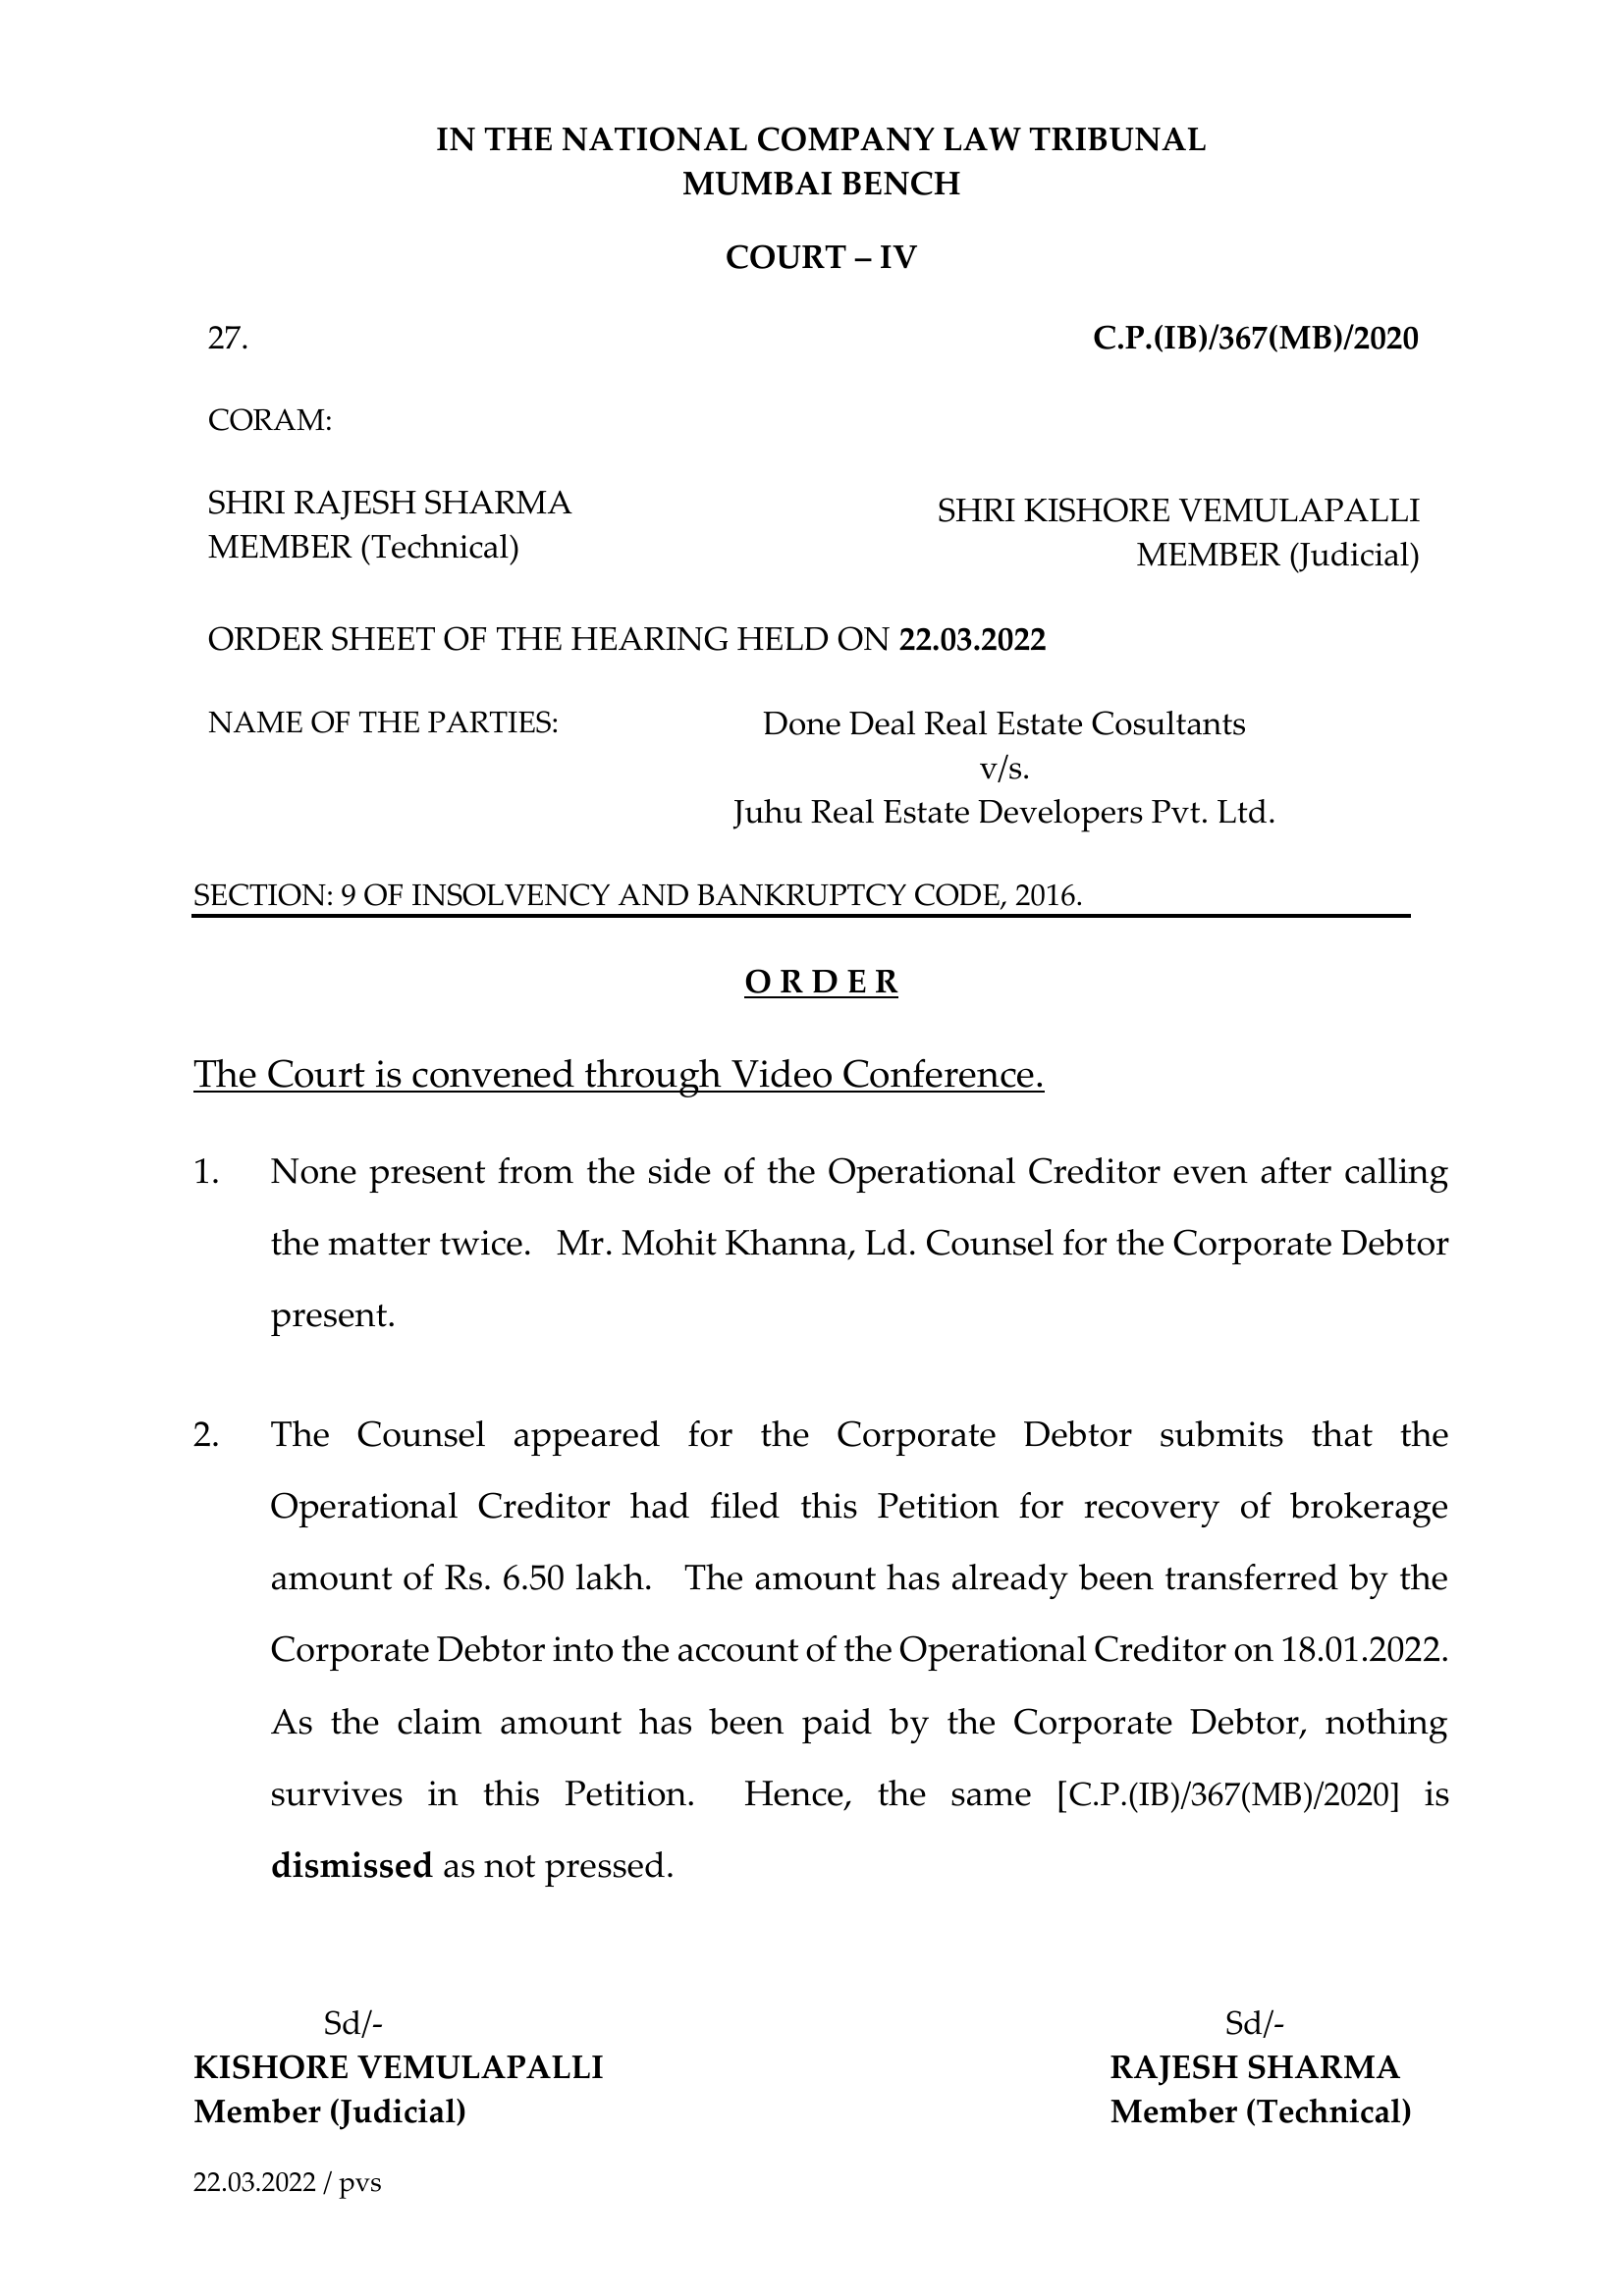

In [ ]:
pdf_blob = df["pdf_blob"][144] # The blob of the first order

convert_from_bytes(pdf_blob)[0] # Displaying the first page of the order

<b> Figure 3: </b> Preview of sample order.

## 3.6 Extract text from PDFs

To apply NLP techniques, the text must first be extracted from the PDFs.

In most cases, the text is embedded in the PDF, which means it can be easily extracted. In other cases, optical character recognition (OCR) is used to extract the text, which means converting images of text into editable and searchable formats.

The `read_pdf_text_from_blob` function reads text from byte data. When text is embedded in the PDF, `pdfplumber` extracts it directly. If this extraction fails, `tesseract` applies OCR to retrieve the text.

While the extraction may not be flawless, it is generally adequate for NLP tasks. Instances where watermarks or handheld scanning hinder extraction exit, but they rare.

As an example, we extract the text of the first PDF file in the database, which is shown section 4.7.

In [ ]:
read_pdf_text_from_blob(df["pdf_blob"][0])

'SHARAYUPANDURANGKHOT\n\nDigitallysigned bySHARAYUPANDURANGKHOT\nDate:2021.12.1317:40:43+0530\n\n\n**_2-COMS-52-21.doc_**\n\nSharayu Khot.\n\n# IN THE HIGH COURT OF JUDICATURE AT BOMBA ORDINARY ORIGINAL CIVIL JURISDICTIO COMMERCIAL SUIT NO. 52 OF 202 Reliance Industries Limited …Plaintif Versu The New India Assurance Company …Defendant Limited & Ors --------- Ms. Reshma Ranadive i/by A.S. Dayal and Associates for th Plaintiff Mr. Sankalp Srivastava iby M/s. Mulla & Mulla and Craigi Blunt and Caroe for the Defendant Nos. 1 to 8 --------- CORAM  : R.I. CHAGLA             DATE    : 10 December 202 ORDER 1. Learned Counsel appearing for the Plaintiff seek leave of this Court to withdraw the Suit unconditionally 2. The Suit is disposed of as withdrawn 3. Court fees are to be refunded in accordance with th Rules. For the purposes of Section 43 of the Maharashtra Court\n\n1/2\n\n\n-----\n\n**_2-COMS-52-21.doc_**\n\n# Fees Act and the proviso to that Section, today’s date is th date of making 

We use the `apply` method from `pandas` to extract the text of all the files. We store in new column called `pdf_text`.

In [ ]:
df["pdf_text"] = df["pdf_blob"].apply(read_pdf_text_from_blob) # This will take some time to execute

In [ ]:
df[['pdf_blob', 'pdf_name', 'pdf_text', 'disposal_type', 'reason']].head(3)

,pdf_blob,pdf_name,pdf_text,disposal_type,reason
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,SHARAYUPANDURANGKHOT\n\nDigitallysigned bySHAR...,Withdrawn,No reason stated
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-1355-2019_10022020.pdf,sbw\n\n\n3.coms-1355-19.doc\n\n# Jayant Furnis...,Withdrawn,No reason stated
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-172-2022_28062022.pdf,```\nSharayu Khot.\n\n```\n```\n ...,Settlement,Consent terms


# 4. Unsupervised classification through Large Language Models

A major advantage of using large language models (LLMs) for this task is that they eliminate the need for labeled training data, which is often expensive and time-consuming to produce. Instead of relying on manually annotated datasets, the model leverages its pre-trained knowledge to analyze the text of court orders directly. It classifies orders by recognizing patterns and structures learned from extensive training on large text corpora.

In this unsupervised approach, the LLM identifies relevant features and characteristics of the text without predefined labels. We provide the LLM with instructions similar to the guidelines given to a law intern for making the classification. The model uses its contextual understanding and semantic insights to determine whether a court order is substantive or non-substantive, enabling effective classification without manual labeling.

We install and use Ollama, an open-source tool that facilitates working with LLMs locally. Ollama offers an easy-to-use interface for managing models, enabling deployment on local machines without requiring cloud-based solutions. Running LLMs locally, like the 27-billion-parameter Gemma 2 model by Google, provides flexibility and control. Other similar models can also be used in this setup.

Language model APIs by [OpenAI](https://platform.openai.com/), [Groq](https://groq.com/), can also be used instead of an LLM running locally.  

## 4.1 Setting up

In this cell, we download and install Ollama by executing a script from the Ollama website using a shell command. After installation, the Ollama server is started, and the specified model (`gemma2:27b`) is downloaded from the Ollama library.

The form input allows you to change the model, with a full list of available models found on their [website](https://ollama.com/library/).

The model runs in the background, enabling it to be used for processing tasks locally, without relying on cloud-based services.

**Note:** Commands starting with `!` are bash commands executed directly in the shell.

In [ ]:
import subprocess
import shutil

MODEL_NAME = "gemma3:12b" # @param {"type":"string","placeholder":"Model Name"}

# Check if ollama is already installed by looking for the 'ollama' command
if shutil.which("ollama") is None:
    # Install Ollama if it's not already installed
    subprocess.run("curl -fsSL https://ollama.com/install.sh | sh", shell=True, capture_output=True)
    print("Ollama installed.")
else:
    print("Ollama is already installed. Skipping installation.")

subprocess.run("nohup ollama serve &", shell=True, capture_output=True)

# Pull the model (replace MODEL_NAME with the actual model name)
subprocess.run(f"ollama pull {MODEL_NAME}", shell=True, capture_output=True)

# Run the model in the background
subprocess.run(f"nohup ollama run {MODEL_NAME} &", shell=True, capture_output=True)
print(f"Model {MODEL_NAME} is now running in the background.")

Ollama is already installed. Skipping installation.
Model gemma3:12b is now running in the background.


We initiate the model using Langchain's Ollama constructor.

In [ ]:
# @title 4.1.2 Initiate the LLM
llm = Ollama(model=MODEL_NAME, temperature=0.5)

In [ ]:
llm.invoke("hi")

'Hi there! 😊 \n\nHow can I help you today?'

## 4.2 Order classifying prompt

We prompt the LLM to classify the order using the same rules provided to law interns for labeling.

In this cell, we create a function that takes the order text as input and returns the disposal type and reason for disposal.

In [ ]:
def classify_using_llm(llm, order_text):
    """
    Classifies a court order text into disposal types using an LLM.

    Args:
        llm: The language model instance.
        order_text: The text of the court order.

    Returns:
        The disposal type number (1-6).
    """

    prompt = f"""
    You are a highly accurate legal document classifier. Your task is to analyze a court order text and determine its disposal type.

    **Classification Rules and Hierarchy:**

    1. **Priority Rule (Override):** If the order text explicitly states a previous ruling as "Allowed," classify the order as "1" (Allowed), regardless of any subsequent proceedings mentioned UNLESS there is an explicit withdrawal of the "Allowed" ruling.
    2. **Main vs. Interim Rule:** If the order text includes both a main application (MA) and an interim application (IA), classify based on the MA disposal.
    3. **Detailed Classification:** If neither Priority Rule nor Main vs. Interim Rule applies, use the following classification rules:

    **Disposal Types and Classification Criteria:**

    * **1. Allowed:**
        * The court grants the petition/application, makes a final order in favor of the petitioner, sanctions a proposed action, or permits dissolution.
        * **Keywords:** "petition is allowed," "application granted," "court hereby sanctions," "order for dissolution," "judgment in favor of..."
        * Must contain a clear and direct statement of allowance.

    * **2. Dismissed:**
        * The case is rejected due to procedural/jurisdictional issues, lack of merit, or technical grounds.
        * **Keywords:** "case is dismissed," "petition is rejected," "application dismissed," "order of dismissal"
        * **Specific Grounds (Exact Match Required):** "Non-prosecution," "Lack of pecuniary jurisdiction," "Unable to prosecute," "Infructuous" (unless preceded by "Allowed"), "No proof of default," "Inability to pay," "Inability to incur expenditure," "No IBC jurisdiction," "Liability not crystallised"

    * **3. Withdrawn (Explicit Withdrawal Required):**
        * The petitioner withdraws the case, or the court permits withdrawal.
        * **Keywords:** "petitioner withdraws," "application for withdrawal is allowed," "case withdrawn," "withdrawal granted"
        * **Conditions:**
            - The order must contain explicit language indicating withdrawal.
            - If there is both a withdrawal and a settlement, classify as "3" (Withdrawn) only if the text confirms formal withdrawal language. Otherwise, classify as "4" (Settlement).

    * **4. Settlement (Without Explicit Withdrawal):**
        * The case is resolved through a formal settlement agreement or mutual agreement, without explicit withdrawal language.
        * **Keywords:** "settlement agreement," "parties have settled," "case resolved by agreement"
        * **Conditions:**
            - There must be a documented settlement.
            - If explicit withdrawal is stated, classify as "3" (Withdrawn) instead.

    * **5. Transferred:**
        * The case is moved to a different jurisdiction.
        * **Keywords:** "case is transferred," "application for transfer allowed," "transferred to..."
        * The order must specify the transfer destination or basis.

    * **6. Remanded:**
        * The case is sent back to a lower court or officer for reconsideration.
        * **Keywords:** "case is remanded," "matter is remanded," "sent back for reconsideration"

    **Important Clarifications:**
    * If a formal settlement exists AND there is NO explicit withdrawal, classify as "4" (Settlement).
    * If explicit withdrawal is stated, always classify as "3" (Withdrawn), even if a settlement is mentioned.
    * If a dismissal mentions specific grounds, classify as "2" (Dismissed) only if the grounds match exactly.
    * Do not infer classification based on general language—use only the explicit action taken by the court or petitioner.

    **Output Instructions:**
    * Provide ONLY the disposal type number (1-6).
    * Do NOT include any explanations, justifications, or other text.

    **Court Order Text:**

    {order_text}

    Answer:
    """

    # Use the model to classify the order
    classification = llm.invoke(prompt, seed=123)

    return classification


In [ ]:
import re

def extract_classification(disposal_type_llm_string):
    """
    Extracts numerical disposal type and reasoning from LLM response.
    Returns dictionary with 'disposal_label' and 'reason' keys.
    """
    result = {
        "disposal_label": "Unknown",
        "reason": None
    }

    # Extract reasoning from <think> tags
    reason_match = re.search(r'<think>(.*?)</think>', disposal_type_llm_string, re.DOTALL)
    if reason_match:
        result['reason'] = reason_match.group(1).strip()

    # Extract disposal number (enhanced pattern)
    number_match = re.search(r'\b([1-5])\b', disposal_type_llm_string[-4:].strip())


    if number_match:
        disposal_labels = {
            "1": "Allowed",
            "2": "Dismissed",
            "3": "Withdrawn",
            "4": "Settlement",
            "5": "Transferred",
            "6": "Remanded",
        }
        result['disposal_label'] = disposal_labels.get(
            number_match.group(1),
            "Unknown"
        )

    return result

## 4.3 Classifying orders

In [ ]:
for index, row in tqdm(df.iterrows(), total=len(df)):
  core_text = row['pdf_text'][-2000:]
  classification = classify_using_llm(llm, core_text)
  disposal_type = extract_classification(classification)["disposal_label"]
  reason = extract_classification(classification)["reason"]
  df.at[index, 'disposal_type_llm'] = disposal_type
  df.at[index, 'reason_llm'] = reason
  print()
  print(df.at[index, 'disposal_type'])
  print(disposal_type)
  print("########")
  if disposal_type != df.at[index, 'disposal_type']:
    print(reason)
  else:
    print("correct disposal type")

  1%|▋                                                                                                    | 1/146 [00:01<04:26,  1.84s/it]


Withdrawn
Withdrawn
########
correct disposal type


  1%|█▍                                                                                                   | 2/146 [00:02<02:24,  1.00s/it]


Withdrawn
Withdrawn
########
correct disposal type


  2%|██                                                                                                   | 3/146 [00:03<02:34,  1.08s/it]


Settlement
Settlement
########
correct disposal type


  3%|██▊                                                                                                  | 4/146 [00:04<02:06,  1.13it/s]


Withdrawn
Withdrawn
########
correct disposal type


  3%|███▍                                                                                                 | 5/146 [00:04<01:42,  1.37it/s]


Withdrawn
Withdrawn
########
correct disposal type


  4%|████▏                                                                                                | 6/146 [00:05<01:32,  1.51it/s]


Withdrawn
Withdrawn
########
correct disposal type


  5%|████▊                                                                                                | 7/146 [00:05<01:23,  1.67it/s]


Withdrawn
Withdrawn
########
correct disposal type


  5%|█████▌                                                                                               | 8/146 [00:06<01:43,  1.33it/s]


Settlement
Settlement
########
correct disposal type


  6%|██████▏                                                                                              | 9/146 [00:07<02:00,  1.14it/s]


Withdrawn
Withdrawn
########
correct disposal type


  7%|██████▊                                                                                             | 10/146 [00:08<02:03,  1.10it/s]


Withdrawn
Withdrawn
########
correct disposal type


  8%|███████▌                                                                                            | 11/146 [00:09<01:49,  1.23it/s]


Settlement
Settlement
########
correct disposal type


  8%|████████▏                                                                                           | 12/146 [00:10<02:04,  1.07it/s]


Withdrawn
Withdrawn
########
correct disposal type


  9%|████████▉                                                                                           | 13/146 [00:11<01:53,  1.17it/s]


Settlement
Settlement
########
correct disposal type


 10%|█████████▌                                                                                          | 14/146 [00:12<01:57,  1.13it/s]


Settlement
Settlement
########
correct disposal type


 10%|██████████▎                                                                                         | 15/146 [00:12<01:50,  1.19it/s]


Settlement
Allowed
########
None


 11%|██████████▉                                                                                         | 16/146 [00:13<01:40,  1.30it/s]


Withdrawn
Withdrawn
########
correct disposal type


 12%|███████████▋                                                                                        | 17/146 [00:13<01:27,  1.48it/s]


Withdrawn
Withdrawn
########
correct disposal type


 12%|████████████▎                                                                                       | 18/146 [00:14<01:14,  1.72it/s]


Settlement
Settlement
########
correct disposal type


 13%|█████████████                                                                                       | 19/146 [00:15<01:40,  1.27it/s]


Settlement
Settlement
########
correct disposal type


 14%|█████████████▋                                                                                      | 20/146 [00:16<01:36,  1.30it/s]


Settlement
Settlement
########
correct disposal type


 14%|██████████████▍                                                                                     | 21/146 [00:16<01:33,  1.34it/s]


Withdrawn
Withdrawn
########
correct disposal type


 15%|███████████████                                                                                     | 22/146 [00:17<01:39,  1.24it/s]


Settlement
Settlement
########
correct disposal type


 16%|███████████████▊                                                                                    | 23/146 [00:18<01:44,  1.18it/s]


Withdrawn
Withdrawn
########
correct disposal type


 16%|████████████████▍                                                                                   | 24/146 [00:19<01:34,  1.29it/s]


Withdrawn
Withdrawn
########
correct disposal type


 17%|█████████████████                                                                                   | 25/146 [00:21<02:03,  1.02s/it]


Settlement
Settlement
########
correct disposal type


 18%|█████████████████▊                                                                                  | 26/146 [00:21<01:49,  1.10it/s]


Withdrawn
Withdrawn
########
correct disposal type


 18%|██████████████████▍                                                                                 | 27/146 [00:22<01:37,  1.22it/s]


Settlement
Settlement
########
correct disposal type


 19%|███████████████████▏                                                                                | 28/146 [00:22<01:22,  1.43it/s]


Withdrawn
Withdrawn
########
correct disposal type


 20%|███████████████████▊                                                                                | 29/146 [00:23<01:20,  1.45it/s]


Withdrawn
Withdrawn
########
correct disposal type


 21%|████████████████████▌                                                                               | 30/146 [00:24<01:48,  1.07it/s]


Settlement
Allowed
########
None


 21%|█████████████████████▏                                                                              | 31/146 [00:25<01:47,  1.07it/s]


Withdrawn
Withdrawn
########
correct disposal type


 22%|█████████████████████▉                                                                              | 32/146 [00:26<01:28,  1.28it/s]


Withdrawn
Withdrawn
########
correct disposal type


 23%|██████████████████████▌                                                                             | 33/146 [00:27<01:33,  1.21it/s]


Settlement
Settlement
########
correct disposal type


 23%|███████████████████████▎                                                                            | 34/146 [00:27<01:25,  1.31it/s]


Withdrawn
Withdrawn
########
correct disposal type


 24%|███████████████████████▉                                                                            | 35/146 [00:28<01:31,  1.21it/s]


Settlement
Settlement
########
correct disposal type


 25%|████████████████████████▋                                                                           | 36/146 [00:29<01:17,  1.42it/s]


Withdrawn
Allowed
########
None


 25%|█████████████████████████▎                                                                          | 37/146 [00:30<01:25,  1.28it/s]


Settlement
Settlement
########
correct disposal type


 26%|██████████████████████████                                                                          | 38/146 [00:31<01:31,  1.19it/s]


Allowed
Allowed
########
correct disposal type


 27%|██████████████████████████▋                                                                         | 39/146 [00:32<01:32,  1.16it/s]


Withdrawn
Withdrawn
########
correct disposal type


 27%|███████████████████████████▍                                                                        | 40/146 [00:32<01:33,  1.13it/s]


Settlement
Settlement
########
correct disposal type


 28%|████████████████████████████                                                                        | 41/146 [00:33<01:28,  1.18it/s]


Settlement
Settlement
########
correct disposal type


 29%|████████████████████████████▊                                                                       | 42/146 [00:35<01:43,  1.01it/s]


Settlement
Settlement
########
correct disposal type


 29%|█████████████████████████████▍                                                                      | 43/146 [00:36<01:47,  1.04s/it]


Withdrawn
Withdrawn
########
correct disposal type


 30%|██████████████████████████████▏                                                                     | 44/146 [00:36<01:28,  1.15it/s]


Withdrawn
Withdrawn
########
correct disposal type


 31%|██████████████████████████████▊                                                                     | 45/146 [00:37<01:13,  1.37it/s]


Withdrawn
Withdrawn
########
correct disposal type


 32%|███████████████████████████████▌                                                                    | 46/146 [00:37<01:15,  1.32it/s]


Settlement
Settlement
########
correct disposal type


 32%|████████████████████████████████▏                                                                   | 47/146 [00:38<01:14,  1.33it/s]


Settlement
Settlement
########
correct disposal type


 33%|████████████████████████████████▉                                                                   | 48/146 [00:44<03:35,  2.20s/it]


Settlement
Unknown
########
None


 34%|█████████████████████████████████▌                                                                  | 49/146 [00:46<03:28,  2.15s/it]


Withdrawn
Withdrawn
########
correct disposal type


 34%|██████████████████████████████████▏                                                                 | 50/146 [00:46<02:41,  1.69s/it]


Withdrawn
Withdrawn
########
correct disposal type


 35%|██████████████████████████████████▉                                                                 | 51/146 [00:47<02:12,  1.39s/it]


Allowed
Allowed
########
correct disposal type


 36%|███████████████████████████████████▌                                                                | 52/146 [00:47<01:40,  1.07s/it]


Allowed
Allowed
########
correct disposal type


 36%|████████████████████████████████████▎                                                               | 53/146 [00:48<01:26,  1.07it/s]


Withdrawn
Dismissed
########
None


 37%|████████████████████████████████████▉                                                               | 54/146 [00:49<01:31,  1.01it/s]


Withdrawn
Withdrawn
########
correct disposal type


 38%|█████████████████████████████████████▋                                                              | 55/146 [00:50<01:13,  1.24it/s]


Withdrawn
Withdrawn
########
correct disposal type


 38%|██████████████████████████████████████▎                                                             | 56/146 [00:50<01:11,  1.26it/s]


Withdrawn
Dismissed
########
None


 40%|███████████████████████████████████████▋                                                            | 58/146 [00:51<00:53,  1.63it/s]


Allowed
Allowed
########
correct disposal type

Withdrawn
Settlement
########
None


 40%|████████████████████████████████████████▍                                                           | 59/146 [00:52<00:59,  1.46it/s]


Withdrawn
Withdrawn
########
correct disposal type


 41%|█████████████████████████████████████████                                                           | 60/146 [00:52<00:49,  1.72it/s]


Dismissed
Dismissed
########
correct disposal type


 42%|█████████████████████████████████████████▊                                                          | 61/146 [00:53<00:50,  1.69it/s]


Dismissed
Dismissed
########
correct disposal type


 42%|██████████████████████████████████████████▍                                                         | 62/146 [00:54<00:49,  1.71it/s]


Dismissed
Dismissed
########
correct disposal type


 44%|███████████████████████████████████████████▊                                                        | 64/146 [00:54<00:36,  2.24it/s]


Dismissed
Dismissed
########
correct disposal type

Allowed
Settlement
########
None


 45%|████████████████████████████████████████████▌                                                       | 65/146 [00:54<00:28,  2.85it/s]


Withdrawn
Settlement
########
None


 45%|█████████████████████████████████████████████▏                                                      | 66/146 [00:56<00:44,  1.81it/s]


Withdrawn
Withdrawn
########
correct disposal type


 47%|██████████████████████████████████████████████▌                                                     | 68/146 [00:56<00:33,  2.32it/s]


Settlement
Dismissed
########
None

Withdrawn
Settlement
########
None


 47%|███████████████████████████████████████████████▎                                                    | 69/146 [00:57<00:38,  1.99it/s]


Withdrawn
Withdrawn
########
correct disposal type


 48%|███████████████████████████████████████████████▉                                                    | 70/146 [00:57<00:39,  1.92it/s]


Dismissed
Dismissed
########
correct disposal type


 49%|████████████████████████████████████████████████▋                                                   | 71/146 [00:59<00:52,  1.43it/s]


Withdrawn
Withdrawn
########
correct disposal type


 49%|█████████████████████████████████████████████████▎                                                  | 72/146 [01:00<00:57,  1.30it/s]


Withdrawn
Withdrawn
########
correct disposal type


 50%|██████████████████████████████████████████████████                                                  | 73/146 [01:00<00:44,  1.64it/s]


Withdrawn
Settlement
########
None


 51%|██████████████████████████████████████████████████▋                                                 | 74/146 [01:01<00:53,  1.34it/s]


Withdrawn
Withdrawn
########
correct disposal type


 51%|███████████████████████████████████████████████████▎                                                | 75/146 [01:02<00:58,  1.21it/s]


Withdrawn
Withdrawn
########
correct disposal type


 52%|████████████████████████████████████████████████████                                                | 76/146 [01:02<00:52,  1.33it/s]


Settlement
Unknown
########
None


 53%|████████████████████████████████████████████████████▋                                               | 77/146 [01:03<00:46,  1.49it/s]


Dismissed
Dismissed
########
correct disposal type


 53%|█████████████████████████████████████████████████████▍                                              | 78/146 [01:03<00:39,  1.72it/s]


Allowed
Unknown
########
None


 54%|██████████████████████████████████████████████████████                                              | 79/146 [01:04<00:45,  1.46it/s]


Withdrawn
Allowed
########
None


 55%|██████████████████████████████████████████████████████▊                                             | 80/146 [01:05<00:49,  1.34it/s]


Dismissed
Dismissed
########
correct disposal type


 55%|███████████████████████████████████████████████████████▍                                            | 81/146 [01:06<00:52,  1.25it/s]


Withdrawn
Withdrawn
########
correct disposal type


 56%|████████████████████████████████████████████████████████▏                                           | 82/146 [01:07<00:50,  1.27it/s]


Withdrawn
Withdrawn
########
correct disposal type


 57%|████████████████████████████████████████████████████████▊                                           | 83/146 [01:08<00:50,  1.24it/s]


Allowed
Allowed
########
correct disposal type


 58%|█████████████████████████████████████████████████████████▌                                          | 84/146 [01:08<00:49,  1.26it/s]


Withdrawn
Withdrawn
########
correct disposal type


 58%|██████████████████████████████████████████████████████████▏                                         | 85/146 [01:09<00:51,  1.18it/s]


Allowed
Allowed
########
correct disposal type


 59%|██████████████████████████████████████████████████████████▉                                         | 86/146 [01:10<00:48,  1.25it/s]


Dismissed
Dismissed
########
correct disposal type


 60%|███████████████████████████████████████████████████████████▌                                        | 87/146 [01:11<00:45,  1.30it/s]


Dismissed
Dismissed
########
correct disposal type


 60%|████████████████████████████████████████████████████████████▎                                       | 88/146 [01:12<00:48,  1.19it/s]


Allowed
Allowed
########
correct disposal type


 61%|████████████████████████████████████████████████████████████▉                                       | 89/146 [01:12<00:44,  1.29it/s]


Dismissed
Dismissed
########
correct disposal type


 62%|█████████████████████████████████████████████████████████████▋                                      | 90/146 [01:13<00:40,  1.37it/s]


Dismissed
Dismissed
########
correct disposal type


 62%|██████████████████████████████████████████████████████████████▎                                     | 91/146 [01:14<00:43,  1.25it/s]


Dismissed
Dismissed
########
correct disposal type


 63%|███████████████████████████████████████████████████████████████                                     | 92/146 [01:15<00:44,  1.22it/s]


Dismissed
Dismissed
########
correct disposal type


 64%|███████████████████████████████████████████████████████████████▋                                    | 93/146 [01:16<00:44,  1.20it/s]


Dismissed
Dismissed
########
correct disposal type


 64%|████████████████████████████████████████████████████████████████▍                                   | 94/146 [01:17<00:48,  1.08it/s]


Withdrawn
Dismissed
########
None


 65%|█████████████████████████████████████████████████████████████████                                   | 95/146 [01:18<00:43,  1.17it/s]


Withdrawn
Withdrawn
########
correct disposal type


 66%|█████████████████████████████████████████████████████████████████▊                                  | 96/146 [01:18<00:43,  1.16it/s]


Withdrawn
Allowed
########
None


 66%|██████████████████████████████████████████████████████████████████▍                                 | 97/146 [01:19<00:40,  1.20it/s]


Withdrawn
Allowed
########
None


 67%|███████████████████████████████████████████████████████████████████                                 | 98/146 [01:20<00:40,  1.20it/s]


Allowed
Allowed
########
correct disposal type


 68%|███████████████████████████████████████████████████████████████████▊                                | 99/146 [01:21<00:39,  1.19it/s]


Dismissed
Dismissed
########
correct disposal type


 68%|███████████████████████████████████████████████████████████████████▊                               | 100/146 [01:22<00:38,  1.21it/s]


Allowed
Allowed
########
correct disposal type


 69%|████████████████████████████████████████████████████████████████████▍                              | 101/146 [01:23<00:40,  1.12it/s]


Withdrawn
Withdrawn
########
correct disposal type


 70%|█████████████████████████████████████████████████████████████████████▏                             | 102/146 [01:24<00:39,  1.11it/s]


Allowed
Allowed
########
correct disposal type


 71%|█████████████████████████████████████████████████████████████████████▊                             | 103/146 [01:25<00:40,  1.06it/s]


Withdrawn
Allowed
########
None


 71%|██████████████████████████████████████████████████████████████████████▌                            | 104/146 [01:25<00:37,  1.13it/s]


Dismissed
Dismissed
########
correct disposal type


 72%|███████████████████████████████████████████████████████████████████████▏                           | 105/146 [01:26<00:33,  1.21it/s]


Withdrawn
Withdrawn
########
correct disposal type


 73%|███████████████████████████████████████████████████████████████████████▉                           | 106/146 [01:27<00:33,  1.20it/s]


Withdrawn
Allowed
########
None


 73%|████████████████████████████████████████████████████████████████████████▌                          | 107/146 [01:28<00:29,  1.30it/s]


Dismissed
Dismissed
########
correct disposal type


 74%|█████████████████████████████████████████████████████████████████████████▏                         | 108/146 [01:29<00:31,  1.21it/s]


Allowed
Allowed
########
correct disposal type


 75%|█████████████████████████████████████████████████████████████████████████▉                         | 109/146 [01:29<00:30,  1.21it/s]


Withdrawn
Allowed
########
None


 75%|██████████████████████████████████████████████████████████████████████████▌                        | 110/146 [01:30<00:27,  1.29it/s]


Withdrawn
Dismissed
########
None


 76%|███████████████████████████████████████████████████████████████████████████▎                       | 111/146 [01:31<00:30,  1.17it/s]


Withdrawn
Withdrawn
########
correct disposal type


 77%|███████████████████████████████████████████████████████████████████████████▉                       | 112/146 [01:32<00:31,  1.06it/s]


Allowed
Allowed
########
correct disposal type


 77%|████████████████████████████████████████████████████████████████████████████▌                      | 113/146 [01:33<00:28,  1.16it/s]


Withdrawn
Withdrawn
########
correct disposal type


 78%|█████████████████████████████████████████████████████████████████████████████▎                     | 114/146 [01:33<00:25,  1.27it/s]


Withdrawn
Withdrawn
########
correct disposal type


 79%|█████████████████████████████████████████████████████████████████████████████▉                     | 115/146 [01:35<00:26,  1.16it/s]


Dismissed
Dismissed
########
correct disposal type


 79%|██████████████████████████████████████████████████████████████████████████████▋                    | 116/146 [01:35<00:25,  1.19it/s]


Dismissed
Dismissed
########
correct disposal type


 80%|███████████████████████████████████████████████████████████████████████████████▎                   | 117/146 [01:36<00:23,  1.25it/s]


Withdrawn
Withdrawn
########
correct disposal type


 81%|████████████████████████████████████████████████████████████████████████████████                   | 118/146 [01:37<00:21,  1.31it/s]


Withdrawn
Withdrawn
########
correct disposal type


 82%|████████████████████████████████████████████████████████████████████████████████▋                  | 119/146 [01:37<00:20,  1.34it/s]


Withdrawn
Withdrawn
########
correct disposal type


 82%|█████████████████████████████████████████████████████████████████████████████████▎                 | 120/146 [01:38<00:18,  1.40it/s]


Withdrawn
Withdrawn
########
correct disposal type


 83%|██████████████████████████████████████████████████████████████████████████████████                 | 121/146 [01:39<00:18,  1.38it/s]


Dismissed
Dismissed
########
correct disposal type


 84%|██████████████████████████████████████████████████████████████████████████████████▋                | 122/146 [01:40<00:17,  1.36it/s]


Dismissed
Dismissed
########
correct disposal type


 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 123/146 [01:40<00:16,  1.42it/s]


Withdrawn
Withdrawn
########
correct disposal type


 85%|████████████████████████████████████████████████████████████████████████████████████               | 124/146 [01:41<00:14,  1.57it/s]


Withdrawn
Withdrawn
########
correct disposal type


 86%|████████████████████████████████████████████████████████████████████████████████████▊              | 125/146 [01:41<00:13,  1.59it/s]


Allowed
Dismissed
########
None


 86%|█████████████████████████████████████████████████████████████████████████████████████▍             | 126/146 [01:42<00:14,  1.39it/s]


Allowed
Allowed
########
correct disposal type


 87%|██████████████████████████████████████████████████████████████████████████████████████             | 127/146 [01:43<00:15,  1.26it/s]


Dismissed
Dismissed
########
correct disposal type


 88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 128/146 [01:44<00:12,  1.43it/s]


Dismissed
Dismissed
########
correct disposal type


 88%|███████████████████████████████████████████████████████████████████████████████████████▍           | 129/146 [01:44<00:11,  1.43it/s]


Dismissed
Dismissed
########
correct disposal type


 89%|████████████████████████████████████████████████████████████████████████████████████████▏          | 130/146 [01:45<00:11,  1.40it/s]


Settlement
Settlement
########
correct disposal type


 90%|████████████████████████████████████████████████████████████████████████████████████████▊          | 131/146 [01:46<00:11,  1.29it/s]


Allowed
Allowed
########
correct disposal type


 90%|█████████████████████████████████████████████████████████████████████████████████████████▌         | 132/146 [01:47<00:11,  1.17it/s]


Withdrawn
Allowed
########
None


 91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 133/146 [01:48<00:11,  1.12it/s]


Withdrawn
Withdrawn
########
correct disposal type


 92%|██████████████████████████████████████████████████████████████████████████████████████████▊        | 134/146 [01:49<00:10,  1.13it/s]


Withdrawn
Allowed
########
None


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌       | 135/146 [01:50<00:09,  1.18it/s]


Withdrawn
Withdrawn
########
correct disposal type


 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 136/146 [01:51<00:08,  1.12it/s]


Withdrawn
Allowed
########
None


 94%|████████████████████████████████████████████████████████████████████████████████████████████▉      | 137/146 [01:51<00:07,  1.20it/s]


Dismissed
Allowed
########
None


 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌     | 138/146 [01:52<00:06,  1.31it/s]


Withdrawn
Withdrawn
########
correct disposal type


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▎    | 139/146 [01:53<00:04,  1.41it/s]


Dismissed
Dismissed
########
correct disposal type


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▉    | 140/146 [01:54<00:04,  1.24it/s]


Withdrawn
Withdrawn
########
correct disposal type


 97%|███████████████████████████████████████████████████████████████████████████████████████████████▌   | 141/146 [01:54<00:03,  1.30it/s]


Withdrawn
Withdrawn
########
correct disposal type


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▎  | 142/146 [01:55<00:02,  1.38it/s]


Withdrawn
Dismissed
########
None


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▉  | 143/146 [01:56<00:02,  1.36it/s]


Withdrawn
Withdrawn
########
correct disposal type


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▋ | 144/146 [01:56<00:01,  1.30it/s]


Dismissed
Dismissed
########
correct disposal type


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▎| 145/146 [01:57<00:00,  1.31it/s]


Dismissed
Dismissed
########
correct disposal type


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [01:58<00:00,  1.23it/s]


Allowed
Allowed
########
correct disposal type


In [ ]:
df.iloc[51]

pdf_blob              b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...
pdf_name                                      oa-1065-2018_14112019.pdf
WHETHERSUBSTANTIVE                                          substantive
court                                                               DRT
disposal_type                                                   Allowed
reason                                                          Allowed
pdf_text              |14.11.2019 Roznama-MDRT-III Next date O.A.106...
disposal_type_llm                                               Allowed
reason_llm                                                         None
Name: 51, dtype: object

In [ ]:
df[['court', 'pdf_name', 'disposal_type', 'reason', 'disposal_type_llm']]

,court,pdf_name,disposal_type,reason,disposal_type_llm
0,BHC,coms-52-2021_10122021.pdf,Withdrawn,No reason stated,Withdrawn
1,BHC,coms-1355-2019_10022020.pdf,Withdrawn,No reason stated,Withdrawn
2,BHC,coms-172-2022_28062022.pdf,Settlement,Consent terms,Settlement
3,BHC,comss-1147-2019_24112021.pdf,Withdrawn,Other,Withdrawn
4,BHC,coms-880-2019_16092019.pdf,Withdrawn,Settlement,Withdrawn
...,...,...,...,...,...
141,NCLT,cp-ib-408-2020_03122021.pdf,Withdrawn,Settlement,Dismissed
142,NCLT,cp-ib-176-2021_28062022.pdf,Withdrawn,Amount part paid,Withdrawn
143,NCLT,cp-ib-4253-2018_01012021.pdf,Dismissed,Non-prosecution,Dismissed
144,NCLT,cp-ib-367-2020_22032022.pdf,Dismissed,Amount paid,Dismissed


In [ ]:
df.iloc[144]["pdf_text"]

'**IN THE NATIONAL COMPANY LAW TRIBUNAL**\n\n**MUMBAI BENCH**\n\n**COURT – IV**\n\n27. **C.P.(IB)/367(MB)/2020**\n\nCORAM:\n\nSHRI RAJESH SHARMA SHRI KISHORE VEMULAPALLI\nMEMBER (Technical) MEMBER (Judicial)\n\nORDER SHEET OF THE HEARING HELD ON 22.03.2022\n\nNAME OF THE PARTIES: Done Deal Real Estate Cosultants\n\nv/s.\n\nJuhu Real Estate Developers Pvt. Ltd.\n\nSECTION: 9 OF INSOLVENCY AND BANKRUPTCY CODE, 2016.\n\n**O R D E R**\n\n# The Court is convened through Video Conference.\n\n## 1. None present from the side of the Operational Creditor even after calling the matter twice.  Mr. Mohit Khanna, Ld. Counsel for the Corporate Debtor present. 2. The Counsel appeared for the Corporate Debtor submits that the Operational Creditor had filed this Petition for recovery of brokerage amount of Rs. 6.50 lakh.  The amount has already been transferred by the Corporate Debtor into the account of the Operational Creditor on 18.01.2022.  As the claim amount has been paid by the Corporate Debtor,

## 4.4 Checking accuracy of LLM

In [ ]:
y_true = df['disposal_type']
y_pred = df['disposal_type_llm']

In [ ]:
import numpy as np
np.unique(y_pred)

array(['Allowed', 'Dismissed', 'Settlement', 'Unknown', 'Withdrawn'],
      dtype=object)

In [ ]:
y_pred = np.where(y_pred == 'Withdrawal', 'Withdrawn', y_pred)
y_pred = np.where(np.isin(y_pred, ['Approved', 'Dissolution', 'allowed and disposed of', 'allowed']), 'Allowed', y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Allowed       0.54      0.83      0.65        18
   Dismissed       0.79      0.96      0.87        28
  Settlement       0.80      0.80      0.80        25
     Unknown       0.00      0.00      0.00         0
   Withdrawn       1.00      0.75      0.85        75

    accuracy                           0.81       146
   macro avg       0.63      0.67      0.64       146
weighted avg       0.87      0.81      0.82       146



/home/ayush/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayush/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayush/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df.drop(["pdf_blob"], axis=1, inplace=True)  # axis=1 is important!

In [ ]:
df.to_excel("disposal_type.xlsx", engine='openpyxl', index=False)